Standardized Data Book:
 - The following book takes the approach of standardizing all NBA data and running it through Darwin.

In [25]:

# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk

In [26]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('piercejkotarski@utexas.edu', '7bA3rFFMcM')

if not status:
    print(msg)

In [27]:
dataset_name = 'nba_data.csv' #we're going to run three simultaneous datasets through darwin, all using this set. 
new_season = "2019_season.csv"
new = pd.read_csv(new_season)

data = pd.read_csv(dataset_name)

data['Playoff result'].replace(0, "NP", inplace = True)  # No playoffs
data['Playoff result'].replace(1, "FR", inplace = True)  # Lost in first round
data['Playoff result'].replace(2, "SF", inplace = True)  # Lost in semi-finals
data['Playoff result'].replace(3, "CF", inplace = True)  # Lost in conference finals
data['Playoff result'].replace(4, "LF", inplace = True)  # Lost in finals
data['Playoff result'].replace(5, "WF", inplace = True)  # Won finals



data = data.rename(index=str, columns={"Games": "G", "Wins": "W", "Losses": "L","# of teams in league": "NUM_TEAMS", 
                                       "Playoff result": "Result", "Mean Age": "Age"})

data["WIN_PCT"] = data['W'] / data['G']
data.drop(['W', 'L', 'PW', 'PL', 'NUM_TEAMS', '2P', '2PA', 'NRtg', "FG", '3P', '3PA', 'TOV', 'SRS'], axis = 1, inplace = True)

data = data[data['G'] >= 81]

#establishes columns for which standardization / normalization is allowed
cols = [col for col in data.columns if col not in ['Team', 'Result', 'NUM_TEAMS', 'G', 'W', 'L', 'PW', 'PL', 'WIN_PCT']]
data.head()

,Team,Year,Result,G,MP,FGA,FG%,3P%,2P%,FT,...,TS%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,WIN_PCT
0,Atlanta Hawks,1983,FR,82,242.1,83.0,0.474,0.217,0.478,22.4,...,0.529,0.476,14.4,31.6,0.270,0.482,15.1,65.2,0.268,0.487805
1,Boston Celtics,1983,WF,82,243.4,88.2,0.500,0.240,0.508,23.3,...,0.554,0.504,14.6,34.2,0.264,0.475,13.8,69.7,0.225,0.756098
2,Chicago Bulls,1983,NP,82,243.7,85.0,0.474,0.171,0.479,22.8,...,0.526,0.475,16.3,32.3,0.268,0.497,15.6,67.2,0.266,0.329268
3,Cleveland Cavaliers,1983,NP,82,242.1,88.2,0.465,0.262,0.470,19.7,...,0.512,0.468,14.0,33.5,0.224,0.490,13.2,70.8,0.280,0.341463
4,Dallas Mavericks,1983,SF,82,243.4,88.2,0.500,0.228,0.507,21.6,...,0.547,0.503,13.6,31.7,0.245,0.503,14.4,65.7,0.232,0.524390


In [28]:
out = ['Team', 'Result', 'G', 'WIN_PCT']

data_std = data[cols].groupby('Year').transform(lambda x: (x - x.mean()) / x.std())
data_std[out] = data[out]

In [29]:
train_std, test_std = train_test_split(data_std, test_size = 0.2)
train_std.head()

,MP,FGA,FG%,3P%,2P%,FT,FTA,FT%,ORB,DRB,...,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,Team,Result,G,WIN_PCT
247,-0.227346,0.094466,-0.419899,-1.107893,-0.462168,-0.938515,-0.901597,-0.266271,-0.836098,-0.657003,...,-1.288713,-0.866084,1.234409,-0.325920,-0.475344,-0.679054,Washington Bullets,NP,82,0.268293
22,0.677169,-1.067985,-0.536376,0.247532,-0.304369,-1.117251,-1.294926,-0.134528,-1.304538,0.205348,...,-1.208509,-0.643765,-0.224875,-0.952044,1.543473,-0.794440,Washington Bullets,FR,82,0.426829
116,-0.573371,-0.429225,1.082424,-1.355584,0.859107,0.138989,-0.097566,0.510922,-0.071217,0.239084,...,0.695759,0.301257,0.237753,-1.308609,1.514106,-0.040357,Boston Celtics,FR,82,0.512195
577,1.833168,-1.013096,2.605608,1.336060,2.577871,0.317810,2.013924,-2.849192,-1.246033,1.803191,...,-0.804813,0.652678,-1.437480,-1.089989,1.753301,-0.139021,Miami Heat,CF,82,0.719512
76,1.652663,0.589030,-0.089830,0.609097,-0.207198,0.419864,0.154910,0.691442,-0.172191,-0.448119,...,-0.430401,0.195635,0.925110,-0.036092,-0.672648,0.328529,Golden State Warriors,SF,82,0.512195


In [30]:
test_std.to_csv(path_or_buf = "test_std.csv")
train_std.to_csv(path_or_buf = "train_std.csv")

std_name = 'train_std.csv'

In [33]:

status, dataset_std = ds.upload_dataset(std_name)
if not status:
    print(dataset_std)

In [34]:
target = "Result"
status, job_id = ds.clean_data(std_name, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-04-23T17:32:14.067102', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_std.csv'], 'artifact_names': ['a72c6538cee5402b849804e81e73f5ea'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T17:32:14.067102', 'endtime': '2019-04-23T17:32:17.391462', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_std.csv'], 'artifact_names': ['a72c6538cee5402b849804e81e73f5ea'], 'model_name': None, 'job_error': ''}


In [35]:
model_std = target + "_model_std"
status, job_id = ds.create_model(dataset_names = std_name, \
                                 model_name =  model_std, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-04-23T17:32:45.464117', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train_std.csv'], 'artifact_names': None, 'model_name': 'Result_model_std', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:32:45.464117', 'endtime': None, 'percent_complete': 6, 'job_type': 'TrainModel', 'loss': 1.429616928100586, 'generations': 4, 'dataset_names': ['train_std.csv'], 'artifact_names': None, 'model_name': 'Result_model_std', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:32:45.464117', 'endtime': None, 'percent_complete': 6, 'job_type': 'TrainModel', 'loss': 1.429616928100586, 'generations': 4, 'dataset_names': ['train_std.csv'], 'artifact_names': None, 'model_name': 'Result_model_std', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:32:45.464117', 'endtime': None, 'percent_complete': 25, 'job_type': 'TrainModel', 'loss': 0.9355949163

In [36]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = std_name,
                                          model_name = model_std,
                                          max_train_time = '00:05')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Taken', 'starttime': '2019-04-23T17:36:19.30092', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.9583160877227783, 'generations': 7, 'dataset_names': ['train_std.csv'], 'artifact_names': None, 'model_name': 'Result_model_std', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-23T17:36:19.30092', 'endtime': None, 'percent_complete': 1, 'job_type': 'UpdateModel', 'loss': 0.9583160877227783, 'generations': 7, 'dataset_names': ['train_std.csv'], 'artifact_names': None, 'model_name': 'Result_model_std', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:36:19.30092', 'endtime': None, 'percent_complete': 1, 'job_type': 'UpdateModel', 'loss': 0.9583160877227783, 'generations': 7, 'dataset_names': ['train_std.csv'], 'artifact_names': None, 'model_name': 'Result_model_std', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:36:19.30092', 'endtime': None, 'percent_complete': 8, 'job_type': 'UpdateModel', 'loss

In [37]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model_std)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Complete', 'starttime': '2019-04-23T17:37:50.552838', 'endtime': '2019-04-23T17:37:52.114315', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.9061133861541748, 'generations': 11, 'dataset_names': None, 'artifact_names': ['7e95405f5f0d44a9a1d9386a37b58759'], 'model_name': 'Result_model_std', 'job_error': ''}


In [38]:
feature_importance[:30]

MOV           0.185567
WIN_PCT       0.110212
TS%           0.049289
DRtg          0.048400
ORtg          0.044437
DeFG%         0.039392
2P%           0.034143
SOS           0.031017
FG%           0.027270
Age           0.026440
OeFG%         0.024285
PTS           0.022612
DRB           0.019023
STL           0.018273
AST           0.017466
Unnamed: 0    0.017383
OTOV%         0.017074
DRB%          0.016754
DTOV%         0.015840
FT%           0.015788
ORB           0.015678
3PAr          0.015134
FTr           0.014860
3P%           0.013599
FTA           0.013486
TRB           0.013248
OFT/FGA       0.013033
PF            0.012369
ORB%          0.012279
FGA           0.011914
dtype: float64

In [39]:
status, artifact = ds.run_model(std_name, model_std)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-23T17:38:52.74625', 'endtime': '2019-04-23T17:38:53.757578', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.9061133861541748, 'generations': 11, 'dataset_names': ['train_std.csv'], 'artifact_names': ['e031b56c804748fdb7155219a303110d'], 'model_name': 'Result_model_std', 'job_error': ''}


(True, 'Job completed')

In [40]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,Result,prob_CF,prob_FR,prob_LF,prob_NP,prob_SF,prob_WF
0,NP,8.579000e-07,0.001309,1.679000e-07,0.998655,0.000034,9.510000e-08
1,NP,1.361167e-03,0.467488,4.402648e-04,0.493167,0.037373,1.711096e-04
2,FR,8.738759e-03,0.790730,2.859374e-03,0.053365,0.143376,9.315020e-04
3,CF,3.284736e-01,0.074164,1.726213e-01,0.000402,0.268206,1.561319e-01
4,FR,4.798054e-03,0.779534,1.540998e-03,0.113459,0.100149,5.195347e-04


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-macosx-10.6-intel.egg/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          CF       0.30      0.26      0.28        50
          FR       0.66      0.77      0.71       203
          LF       0.00      0.00      0.00        28
          NP       0.94      0.94      0.94       326
          SF       0.33      0.31      0.32       106
          WF       0.56      0.69      0.62        26

   micro avg       0.71      0.71      0.71       739
   macro avg       0.47      0.50      0.48       739
weighted avg       0.68      0.71      0.70       739



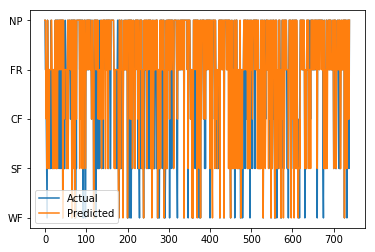

In [41]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(train_std[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(train_std[target], prediction[target]))

In [43]:
test_data = 'test_std.csv'
status, dataset = ds.upload_dataset(test_data)
if not status:
    print(dataset)

In [44]:
# clean test dataset
status, job_id = ds.clean_data(test_data, target = target, model_name = model_std)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T17:39:36.998848', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_std.csv'], 'artifact_names': ['4ffa7350dda14bfb85d5df6aed893c02'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-23T17:39:36.998848', 'endtime': '2019-04-23T17:39:39.3364', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_std.csv'], 'artifact_names': ['4ffa7350dda14bfb85d5df6aed893c02'], 'model_name': None, 'job_error': ''}


In [45]:
status, artifact = ds.run_model(test_data, model_std)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-23T17:39:59.556602', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.9061133861541748, 'generations': 11, 'dataset_names': ['test_std.csv'], 'artifact_names': ['53f94a21ec7e4f82abbcba8573b1f521'], 'model_name': 'Result_model_std', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T17:39:59.556602', 'endtime': '2019-04-23T17:40:01.21826', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.9061133861541748, 'generations': 11, 'dataset_names': ['test_std.csv'], 'artifact_names': ['53f94a21ec7e4f82abbcba8573b1f521'], 'model_name': 'Result_model_std', 'job_error': ''}


(True, 'Job completed')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-macosx-10.6-intel.egg/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          CF       0.22      0.27      0.24        15
          FR       0.70      0.74      0.72        61
          LF       0.00      0.00      0.00         5
          NP       0.90      0.99      0.94        71
          SF       0.44      0.31      0.36        26
          WF       0.29      0.29      0.29         7

   micro avg       0.70      0.70      0.70       185
   macro avg       0.43      0.43      0.43       185
weighted avg       0.67      0.70      0.68       185



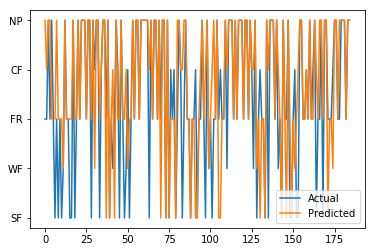

In [46]:
# Create plots comparing predictions with actual target
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(test_data)
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

In [47]:
status, model_type = ds.lookup_model_name(model_std)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'hardtanh', 'numunits': 90}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'hardtanh', 'numunits': 19}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'identity', 'numunits': 44}}}, {'layer 4': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 5}}}, {'layer 5': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 137}}}, {'layer 6': {'type': 'LinearGene', 'parameters': {'activation': 'selu', 'numunits': 58}}}, {'layer 7': {'type': 'LinearGene', 'parameters': {'activation': 'identity', 'numunits': 6}}}]


In [48]:
target = 'Result'
new_season = "2019_season.csv"
model_std = target + "_model_std"
new = pd.read_csv(new_season)
new["WIN_PCT"] = new['W'] / new['G']
new["NUM_TEAMS"] = 30
new["Result"] = ''

cols = [col for col in new.columns if col not in ['Team', 'Result', 'G', 'WIN_PCT']]
out = ['Team', 'Result', 'NUM_TEAMS', 'G', 'WIN_PCT']

std_new = new[cols].transform(lambda x: (x - x.mean()) / x.std())

std_new[out] = new[out]

std_new.head()


,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,NUM_TEAMS,Team,Result,G,WIN_PCT
0,NaN,0.608529,0.195367,1.222952,-0.715298,1.086675,1.161058,-0.228441,-0.605732,-0.530233,...,-0.311183,1.167823,0.389968,-0.380063,2.199444,30,Atlanta Hawks,,82,0.353659
1,NaN,-0.540442,0.614010,0.607531,0.342537,0.821633,0.579754,0.620053,-0.099677,-0.265484,...,-1.249672,-0.720274,1.000352,-0.039708,-0.017050,30,Boston Celtics*,,82,0.597561
2,NaN,2.651142,-0.462501,0.228810,-0.866417,0.954154,0.975040,-0.163172,-1.019776,-0.794981,...,0.627306,-0.860133,-0.830801,-0.380063,-0.471715,30,Brooklyn Nets*,,82,0.512195
3,NaN,0.225539,-0.522307,0.276151,-0.941977,0.357808,0.440241,-0.293709,-0.651737,-0.309609,...,0.330941,0.958035,-0.322147,0.017018,-1.096880,30,Charlotte Hornets,,82,0.475610
4,NaN,1.374509,-0.761531,-0.623311,-0.564179,-1.497492,-1.419932,-0.293709,0.452382,1.058259,...,-0.706337,1.167823,-0.525609,0.130470,-0.585382,30,Chicago Bulls,,82,0.268293


In [49]:

new_std_name = 'std_2019.csv'
std_new.to_csv(path_or_buf = new_std_name)



In [50]:

status, dataset = ds.upload_dataset(new_std_name)
    
if not status:
    print(dataset)


status, job_id = ds.clean_data(new_std_name, target = target, model_name = model_std)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)


status, artifact = ds.run_model(new_std_name, model_std)
sleep(1)
ds.wait_for_job(artifact['job_name'])


status, prediction = ds.download_artifact(artifact['artifact_name'])

print(prediction)


{'status': 'Requested', 'starttime': '2019-04-23T17:40:58.497842', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['std_2019.csv'], 'artifact_names': ['59f6dd0b06bf45bdadf386c4c3177eed'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-23T17:40:58.497842', 'endtime': '2019-04-23T17:41:00.119235', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['std_2019.csv'], 'artifact_names': ['59f6dd0b06bf45bdadf386c4c3177eed'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:41:14.99665', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.9061133861541748, 'generations': 11, 'dataset_names': ['std_2019.csv'], 'artifact_names': ['632751781f1240e081f1306fba1db8de'], 'model_name': 'Result_model_std', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T17:41:14.9

In [51]:
prediction["Team"] = new["Team"]
prediction

,Result,prob_CF,prob_FR,prob_LF,prob_NP,prob_SF,prob_WF,Team
0,NP,3.412760e-05,0.017614,1.024720e-05,0.981326,0.001011,5.362900e-06,Atlanta Hawks
1,SF,1.408887e-01,0.384916,4.454859e-02,0.001952,0.408108,1.958605e-02,Boston Celtics*
2,FR,1.912334e-02,0.747969,6.059252e-03,0.011362,0.213673,1.813252e-03,Brooklyn Nets*
3,NP,4.091631e-04,0.181044,1.354226e-04,0.806180,0.012173,5.921930e-05,Charlotte Hornets
4,NP,6.375300e-06,0.006258,1.591400e-06,0.993501,0.000233,8.571000e-07,Chicago Bulls
5,NP,1.188700e-06,0.001788,2.411000e-07,0.998163,0.000048,1.349000e-07,Cleveland Cavaliers
6,NP,6.753648e-04,0.166885,2.401389e-04,0.816012,0.016077,1.109067e-04,Dallas Mavericks
7,SF,2.050095e-01,0.260288,8.073522e-02,0.001635,0.406263,4.606944e-02,Denver Nuggets*
8,FR,5.972290e-03,0.827310,1.808433e-03,0.049784,0.114555,5.700699e-04,Detroit Pistons*
9,CF,3.053916e-01,0.029704,2.203984e-01,0.000225,0.162583,2.816976e-01,Golden State Warriors*
